In [5]:
import numpy as np
import awkward as ak
import hist
import warnings
import pickle
from coffea.ml_tools.torch_wrapper import torch_wrapper
import matplotlib.pyplot as plt
import hist
from sklearn.metrics import roc_curve, auc
import math
import os
import uproot
import json

In [6]:
warnings.filterwarnings('ignore', 'No format checks')

In [7]:
def signal_read_in(signal_name, msd_up, msd_down, pt_up, pt_down):
    signal = ak.from_parquet(f'/scratch365/cmoore24/training/data/no_subcut/{signal_name}.parquet')
    signal = signal[signal['FatJets.msoftdrop'] < msd_up]
    signal = signal[signal['FatJets.msoftdrop'] > msd_down]
    signal = signal[signal['FatJets.pt'] < pt_up]
    signal = signal[signal['FatJets.pt'] > pt_down]
    signal['FatJets.mratio'] = signal['FatJets.mass']/signal['FatJets.msoftdrop']
    model = model = f'models_and_scalers/qcd/{signal_name}_nosubcut_traced_model.pt'
    with open(f'models_and_scalers/qcd/{signal_name}_nosubcut_scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    return signal, model, scaler

In [8]:
msd_up = 200
msd_down = 40
pt_up = 600
pt_down = 450

In [9]:
use = 'hbb'
#use = 'hgg'
if use == 'hgg':
    signal, model, scaler = signal_read_in('hgg', msd_up, msd_down, pt_up, pt_down)
else:
    signal, model, scaler = signal_read_in('hbb', msd_up, msd_down, pt_up, pt_down)

In [10]:
def bkg_read_in(bkg_name, msd_up, msd_down, pt_up, pt_down):
    bkg = ak.from_parquet(f'/scratch365/cmoore24/training/data/no_subcut/{bkg_name}.parquet')
    bkg = bkg[bkg['FatJets.msoftdrop'] < msd_up]
    bkg = bkg[bkg['FatJets.msoftdrop'] > msd_down]
    bkg = bkg[bkg['FatJets.pt'] < pt_up]
    bkg = bkg[bkg['FatJets.pt'] > pt_down]
    bkg['FatJets.mratio'] = bkg['FatJets.mass']/bkg['FatJets.msoftdrop']
    return bkg

In [11]:
bkg_dict = {}
bkg_dict['qcd'] = bkg_read_in('qcd', msd_up, msd_down, pt_up, pt_down)
bkg_dict['ttboosted'] = bkg_read_in('ttboosted', msd_up, msd_down, pt_up, pt_down)
bkg_dict['wqq'] = bkg_read_in('wqq', msd_up, msd_down, pt_up, pt_down)
bkg_dict['zqq'] = bkg_read_in('zqq', msd_up, msd_down, pt_up, pt_down)
bkg_dict['singletop'] = bkg_read_in('singletop', msd_up, msd_down, pt_up, pt_down)
bkg_dict['ww'] = bkg_read_in('ww', msd_up, msd_down, pt_up, pt_down)
bkg_dict['wz'] = bkg_read_in('wz', msd_up, msd_down, pt_up, pt_down)
bkg_dict['zz'] = bkg_read_in('zz', msd_up, msd_down, pt_up, pt_down)
if use == 'hgg':
    bkg_dict['hbb'] = bkg_read_in('hbb', msd_up, msd_down, pt_up, pt_down)

In [12]:
class EnergyCorrelatorFunctionTagger(torch_wrapper):
    def prepare_awkward(self, events, scaler):
        fatjets = events

        imap = {
            'vars': {
                'n2b1': fatjets['FatJets.n2b1'],
                'n3b1': fatjets['FatJets.n3b1'],
                'nConstituents': fatjets['FatJets.nConstituents'],
                #'color_ring': fatjets['FatJets.color_ring'],
                'd2b1': fatjets['FatJets.d2b1'],
                'u1': fatjets['FatJets.u1'],
                'u2': fatjets['FatJets.u2'],
                'u3': fatjets['FatJets.u3'],
                'd3': fatjets['FatJets.d3'],
                'm2': fatjets['FatJets.m2'],
                'm3': fatjets['FatJets.m3'],
                'n4': fatjets['FatJets.n4'],
                #'mratio': fatjets['FatJets.mratio'],
            },
        }

        retmap = {
            k: ak.concatenate([x[:, np.newaxis] for x in imap[k].values()], axis=1)
            for k in imap.keys()
        }
        x = ak.values_astype(scaler.transform(retmap['vars']), "float32")
        return (x,), {}

In [13]:
a = EnergyCorrelatorFunctionTagger(model)
sig_score = a(signal, scaler)[:,0]
qcd_score = a(bkg_dict['qcd'], scaler)[:,0]
wqq_score = a(bkg_dict['wqq'], scaler)[:,0]
zqq_score = a(bkg_dict['zqq'], scaler)[:,0]
ttboosted_score = a(bkg_dict['ttboosted'], scaler)[:,0]
singletop_score = a(bkg_dict['singletop'], scaler)[:,0]
ww_score = a(bkg_dict['ww'], scaler)[:,0]
wz_score = a(bkg_dict['wz'], scaler)[:,0]
zz_score = a(bkg_dict['zz'], scaler)[:,0]
if use == 'hgg':
    hbb_score = a(bkg_dict['hbb'], scaler)[:,0]
scores = {}
scores['sig'] = sig_score
scores['qcd'] = qcd_score
scores['wqq'] = wqq_score
scores['zqq'] = zqq_score
scores['ttboosted'] = ttboosted_score
scores['singletop'] = singletop_score
scores['ww'] = ww_score
scores['wz'] = wz_score
scores['zz'] = zz_score
if use == 'hgg':
    scores['hbb'] = hbb_score

In [53]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

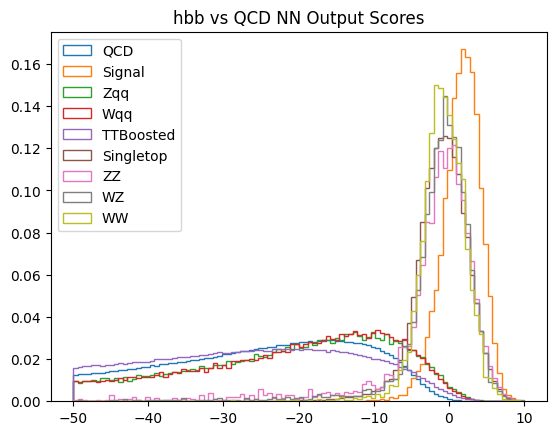

In [58]:
plt.hist(qcd_score, bins=100, range=(-50, 10), label='QCD', density=True, histtype='step')
plt.hist(sig_score, bins=100, range=(-50, 10), label='Signal', density=True, histtype='step')
plt.hist(zqq_score, bins=100, range=(-50, 10), label='Zqq', density=True, histtype='step')
plt.hist(wqq_score, bins=100, range=(-50, 10), label='Wqq', density=True, histtype='step')
plt.hist(ttboosted_score, bins=100, range=(-50, 10), label='TTBoosted', density=True, histtype='step')
plt.hist(singletop_score, bins=100, range=(-50, 10),  label='Singletop', density=True, histtype='step')
plt.hist(zz_score, bins=100, range=(-50, 10), label='ZZ', density=True, histtype='step')
plt.hist(wz_score, bins=100, range=(-50, 10), label='WZ', density=True, histtype='step')
plt.hist(ww_score, bins=100, range=(-50, 10), label='WW', density=True, histtype='step')
if use == 'hgg':
    plt.hist(hbb_score, bins=100, range=(-50, 10), label='Hbb', density=True, histtype='step')
plt.title(f'{use} vs QCD NN Output Scores')
plt.legend()
plt.show()

In [15]:
def msd_plotter(sample, sample_score, density, wp, fail):
    if fail:
        sample_cut_msd = bkg_dict[sample]['FatJets.msoftdrop'][sample_score < wp]
        regime = 'Failing'
    else:
        sample_cut_msd = bkg_dict[sample]['FatJets.msoftdrop'][sample_score > wp]
        regime = 'Passing'
    plt.hist(sample_cut_msd, range=(40,200), bins=30, density=density, histtype='step', label=f'NN Cut {sample}')
    plt.hist(bkg_dict[sample]['FatJets.msoftdrop'], range=(40,200), bins=30, density=density, histtype='step', label=sample)
    plt.legend()
    if density:
        plt.title(f'Density Plot, {sample} With and Without NN Cut, {regime} WP = {wp}')
    else:
        plt.title(f'{sample} With and Without NN Cut, {regime} WP = {wp}')
    plt.show()

In [16]:
def msd_double_plotter(sample, sample_score, wp, fail):
    if fail:
        sample_cut_msd = bkg_dict[sample]['FatJets.msoftdrop'][sample_score < wp]
        regime = 'Failing'
    else:
        sample_cut_msd = bkg_dict[sample]['FatJets.msoftdrop'][sample_score > wp]
        regime = 'Passing'
    plt.figure(figsize=(20, 8), dpi=80)
    ax = plt.subplot(1, 2, 1)
    plt.hist(sample_cut_msd, range=(40,200), bins=30, density=True, histtype='step', label=f'NN Cut {sample}')
    plt.hist(bkg_dict[sample]['FatJets.msoftdrop'], range=(40,200), bins=30, density=True, histtype='step', label=sample)
    plt.legend()
    plt.title(f'Density Plot, {sample} With and Without NN Cut, {regime} WP = {wp}')

    ax = plt.subplot(1, 2, 2)
    plt.hist(sample_cut_msd, range=(40,200), bins=30, density=False, histtype='step', label=f'NN Cut {sample}')
    plt.hist(bkg_dict[sample]['FatJets.msoftdrop'], range=(40,200), bins=30, density=False, histtype='step', label=sample)
    plt.legend()
    plt.title(f'{sample} With and Without NN Cut, {regime} WP = {wp}')

    plt.figure(figsize=(8, 6), dpi=80)
    plt.show()

In [17]:
def make_hist(sample, sample_score):
    min = abs(math.floor(ak.min(sample_score)))
    max = math.ceil(ak.max(sample_score))
    bins = min + max
    score_hist = hist.Hist.new.Reg(bins, -min, max, name=f"NN_Score", label=f"{sample}_NN", overflow=False, underflow=False).Weight()
    score_hist.fill(NN_Score=sample_score)
    return score_hist

In [18]:
qcd_hist = make_hist('qcd', qcd_score)
hbb_hist = make_hist('hbb', sig_score)

In [24]:
ak.min(qcd_score), ak.max(qcd_score), ak.min(sig_score), ak.max(sig_score)

(-317.84656, 5.394144, -23.549997, 9.717648)

In [25]:
def roc_maker(signal_array, bkg_array, sig_score_hist, bkg_score_hist, sig_score, bkg_score, title, include_pn=False):
    bkg_zeros = ak.zeros_like(bkg_score)
    sig_ones = ak.ones_like(sig_score)
    combined = ak.concatenate([bkg_score,sig_score])
    combined_truth = ak.concatenate([bkg_zeros, sig_ones])

    bkg_total = bkg_score_hist[0:bkg_score_hist.size:sum]
    sig_total = sig_score_hist[0:sig_score_hist.size:sum]

    wp_dict = {}

    bkg_min = abs(int(bkg_score_hist.to_numpy()[1][0]))
    sig_min = abs(int(sig_score_hist.to_numpy()[1][0]))
    
    for i in range(-10, 6, 1):
        bkg_wp_value = bkg_score_hist[bkg_min+i:bkg_score_hist.size:sum]
        bkg_ratio = bkg_wp_value.value/bkg_total.value
    
        sig_wp_value = sig_score_hist[sig_min+i:sig_score_hist.size:sum]
        sig_ratio = sig_wp_value.value/sig_total.value
        wp_dict[i] = [sig_ratio, bkg_ratio]

    if include_pn:
        signal_array['FatJets.isSignal'] = np.ones_like(signal_array['FatJets.particleNetMD_QCD'])
        bkg_array['FatJets.isSignal'] = np.zeros_like(bkg_array['FatJets.particleNetMD_QCD'])
        arg1 = ak.concatenate([signal_array['FatJets.isSignal'], bkg_array['FatJets.isSignal']])
        arg2 = ak.concatenate([signal_array['FatJets.particleNetMD_QCD'], bkg_array['FatJets.particleNetMD_QCD']])  
        arg3 = ak.concatenate([signal_array['FatJets.particleNet_HbbvsQCD'], bkg_array['FatJets.particleNet_HbbvsQCD']])
        
        fpr2, tpr2, thresholds2 = roc_curve(arg1, arg2)
        fpr3, tpr3, thresholds3 = roc_curve(arg1, arg3)
        
        roc_auc2 = auc(tpr2, fpr2)
        roc_auc3 = auc(fpr3, tpr3)

    fig, ax = plt.subplots()
    fpr, tpr, thresholds = roc_curve(combined_truth, combined)
    roc_auc = auc(fpr, tpr)
    ax.set_yscale("log")
    ax.plot(tpr, fpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
    if include_pn:
        ax.plot(fpr2, tpr2, lw=2, color="red", label="PN_MD_QCD auc = %.3f" % (roc_auc2))
        ax.plot(tpr3, fpr3, lw=2, color="orange", label="PN_HbbvQCD auc = %.3f" % (roc_auc3))
    ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle="--", lw=2, color="k", label="random chance")
    ax.set_xlim([0, 1.0])
    ax.set_ylim([1e-6, 1.0])
    ax.set_xlabel("true positive rate")
    ax.set_ylabel("false positive rate")
    ax.set_title(f"{title} ROC curve")

    for i in wp_dict:
        ax.plot(wp_dict[i][0], wp_dict[i][1], 'o', label=f'WP = {str(i)}')
    
    ax.axhline(y=1e-2, color='grey', linestyle='--')
    ax.axhline(y=1e-3, color='grey', linestyle='--')
    ax.axhline(y=1e-4, color='grey', linestyle='--')
    ax.axhline(y=1e-5, color='grey', linestyle='--')
    
    ax.legend(loc="lower right", bbox_to_anchor=(1.5, 0.4))
    
    plt.gcf().text(0.95, 0.3, f'{pt_down} < pt < {pt_up}', fontsize=14)
    plt.gcf().text(0.95, 0.2, f'{msd_down} < msd < {msd_up}', fontsize=14)
    plt.gcf().text(0.95, 0.1, '|η| < 2.4', fontsize=14)
    
    plt.show()

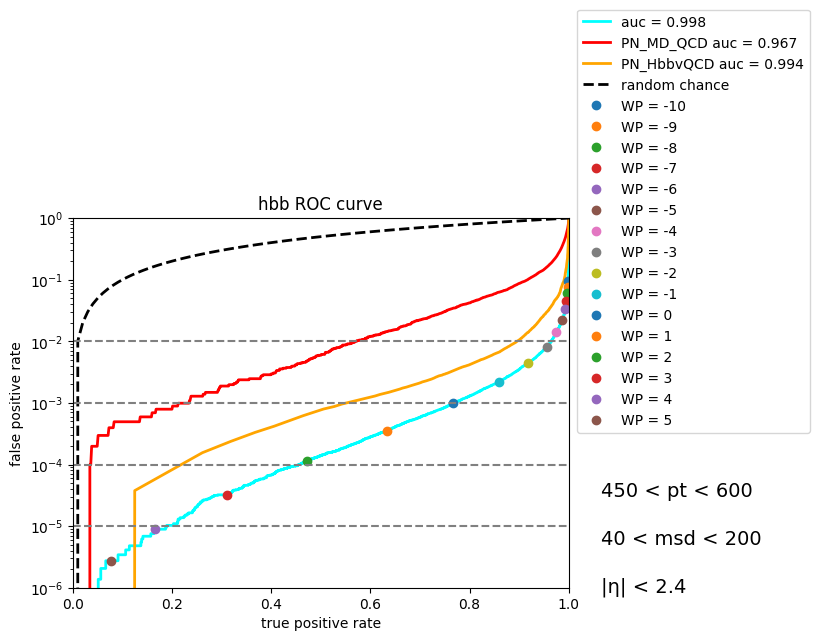

In [26]:
roc_maker(signal, bkg_dict['qcd'], hbb_hist, qcd_hist, sig_score, qcd_score, use, True)

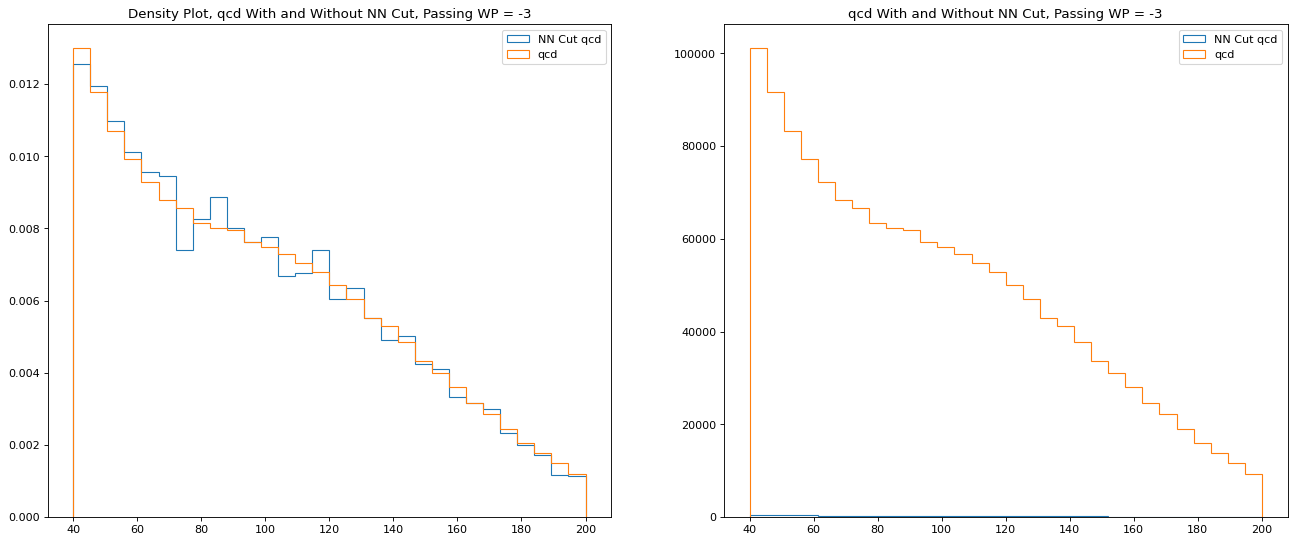

<Figure size 640x480 with 0 Axes>

In [27]:
msd_double_plotter('qcd', ww_score, -3, False)

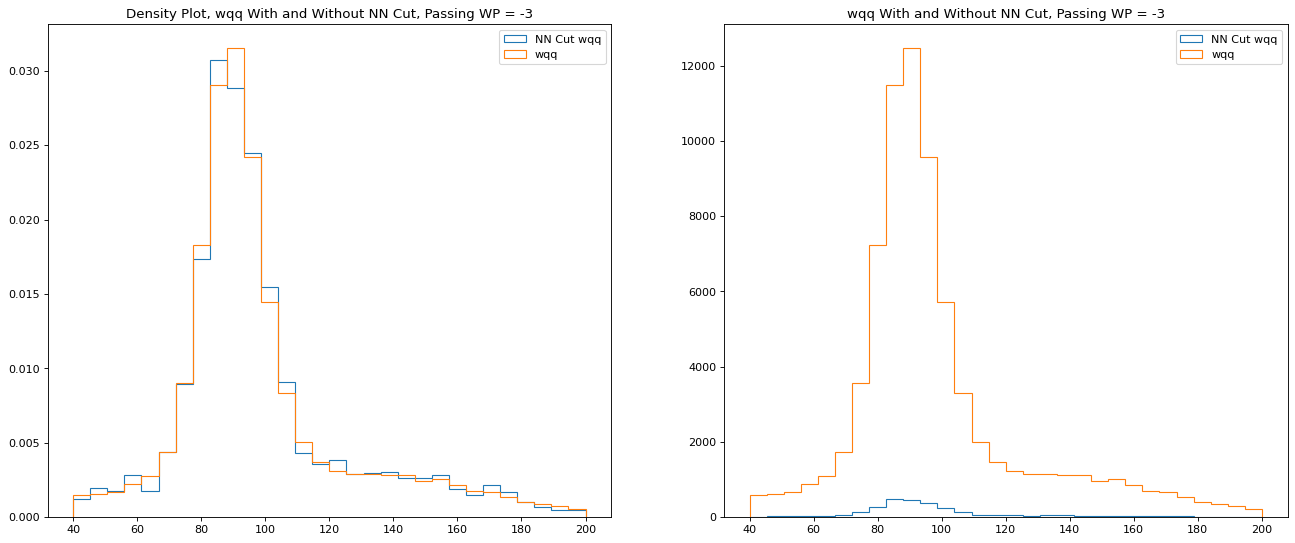

<Figure size 640x480 with 0 Axes>

In [28]:
msd_double_plotter('wqq', wqq_score, -3, False)

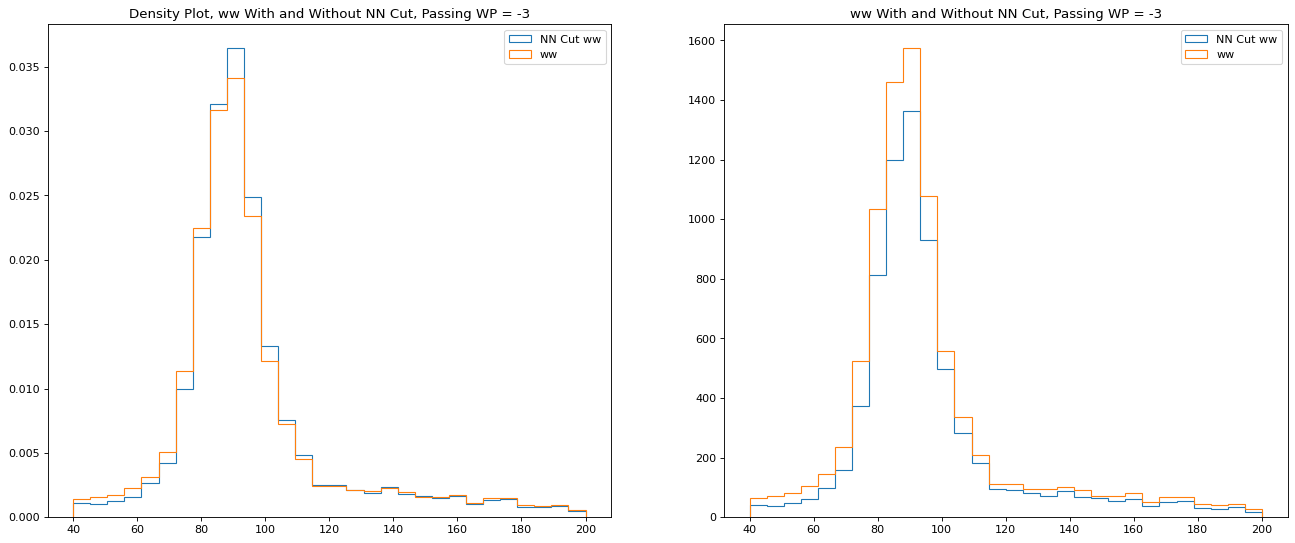

<Figure size 640x480 with 0 Axes>

In [29]:
msd_double_plotter('ww', ww_score, -3, False)

In [30]:
def bkg_output_hist(sample, sample_score, wp, fail):
    if fail:
        sample_cut_msd = bkg_dict[sample]['FatJets.msoftdrop'][sample_score < wp]
    else:
        sample_cut_msd = bkg_dict[sample]['FatJets.msoftdrop'][sample_score > wp]
    msd_hist = hist.Hist.new.Reg(40, msd_down, msd_up, name=f"msd", label=f"{sample} MSD").Weight()
    msd_hist.fill(msd=sample_cut_msd)
    return msd_hist

In [31]:
pass_hists = {}
for i in bkg_dict:
    msd_hist = bkg_output_hist(i, scores[i], wp=-3, fail=False)
    pass_hists[i] = msd_hist
    # with open(f'output_hists/pass/{use}_vs_{i}_pass_wp_3.pkl', 'wb') as f:
    #     pickle.dump(msd_hist, f)

In [32]:
fail_hists = {}
for i in bkg_dict:
    msd_hist = bkg_output_hist(i, scores[i], wp=-3, fail=True)
    fail_hists[i] = msd_hist
    # with open(f'output_hists/fail/{use}_vs_{i}_fail_wp_3.pkl', 'wb') as f:
    #     pickle.dump(msd_hist, f)

In [33]:
sample_cut_msd = signal['FatJets.msoftdrop'][sig_score < -3]
sig_fail_hist = hist.Hist.new.Reg(40, msd_down, msd_up, name=f"msd", label=f"{use} MSD").Weight()
sig_fail_hist.fill(msd=sample_cut_msd);

In [34]:
sample_cut_msd = signal['FatJets.msoftdrop'][sig_score > -3]
sig_pass_hist = hist.Hist.new.Reg(40, msd_down, msd_up, name=f"msd", label=f"{use} MSD").Weight()
sig_pass_hist.fill(msd=sample_cut_msd);

In [35]:
with open('my_xsecs.json', 'rb') as f:
    xsecs = json.load(f)
with open('event_total.json', 'rb') as f:
    event_totals = json.load(f)

In [36]:
event_totals

{'qcd': 149182000,
 'ttboosted': 58671212,
 'wqq': 52907901,
 'zqq': 51157314,
 'hgg': 2392373,
 'hbb': 497000,
 'singletop': 11564999,
 'ww': 9945000,
 'wz': 6681000,
 'zz': 2706000}

In [37]:
xsecs

{'hbb': 0.27395244,
 'hgg': 0.471,
 'qcd': 6833.0,
 'wqq': 59.06,
 'zqq': 25.41,
 'ttboosted': 64.55,
 'singletop': 7.104,
 'ww': 75.83,
 'wz': 27.56,
 'zz': 12.14}

In [38]:
# scaleHgg = ((44.99*(xsecs['hgg']*1000)*0.0817)/(event_totals['hgg']))
# sig_fail_hist.view(flow=True)[:] *= scaleHgg
# sig_pass_hist.view(flow=True)[:] *= scaleHgg
# with open(f'output_hists/fail/{use}_fail_wp_neg1.pkl', 'wb') as f:
#     pickle.dump(sig_fail_hist, f)
# with open(f'output_hists/pass/{use}_pass_wp_neg1.pkl', 'wb') as f:
#     pickle.dump(sig_pass_hist, f)

In [39]:
del(xsecs['hgg'])
del(event_totals['hgg'])

In [40]:
scaleHbb = ((44.99*(xsecs['hbb']*1000)*0.581)/(event_totals['hbb']))
sig_fail_hist.view(flow=True)[:] *= scaleHbb
sig_pass_hist.view(flow=True)[:] *= scaleHbb
with open(f'output_hists/pass/hbb/{use}_fail_wp_neg3.pkl', 'wb') as f:
    pickle.dump(sig_pass_hist, f)
with open(f'output_hists/fail/hbb/{use}_pass_wp_neg3.pkl', 'wb') as f:
    pickle.dump(sig_fail_hist, f)

In [41]:
del(xsecs['hbb'])
del(event_totals['hbb'])

In [42]:
scaled_pass_hists = {}
for i in pass_hists:
    hist2scale = pass_hists[i]
    scale = ((44.99*(xsecs[i]*1000))/event_totals[i])
    hist2scale.view(flow=True)[:] *= scale
    scaled_pass_hists[i] = hist2scale

In [43]:
scaled_fail_hists = {}
for i in fail_hists:
    hist2scale = fail_hists[i]
    scale = ((44.99*(xsecs[i]*1000))/event_totals[i])
    hist2scale.view(flow=True)[:] *= scale
    scaled_fail_hists[i] = hist2scale

In [44]:
for i in scaled_pass_hists:
    with open(f'output_hists/pass/hbb/{use}_vs_{i}_pass_wp_neg3.pkl', 'wb') as f:
        pickle.dump(scaled_pass_hists[i], f)
for i in scaled_fail_hists:
    with open(f'output_hists/fail/hbb/{use}_vs_{i}_fail_wp_neg3.pkl', 'wb') as f:
        pickle.dump(scaled_fail_hists[i], f)

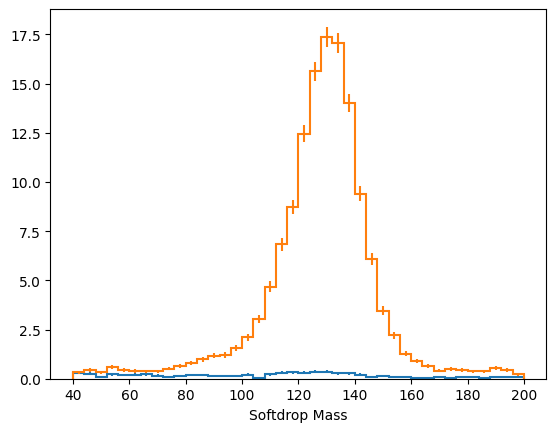

In [48]:
fig, ax = plt.subplots()
sig_fail_hist.plot1d(density=False)
sig_pass_hist.plot1d(density=False)
plt.xlabel('Softdrop Mass')
plt.show()

In [49]:
# fig, ax = plt.subplots()
# fail_hists['hbb'].plot1d(density=True)
# pass_hists['hbb'].plot1d(density=True)
# plt.xlabel('Softdrop Mass')
# plt.show()

In [48]:
fail_hists['qcd']

Hist(Regular(40, 40, 200, name='msd', label='qcd MSD'), storage=Weight()) # Sum: WeightedSum(value=2.98178e+06, variance=6.14449e+06)

In [49]:
pass_hists['qcd']

Hist(Regular(40, 40, 200, name='msd', label='qcd MSD'), storage=Weight()) # Sum: WeightedSum(value=24687, variance=50872)

In [2]:
file = uproot.open('~/Public/combine/CMSSW_13_3_2/src/rhalphalib/run_scripts/hbb_out/testModel/fitDiagnosticsTest.root')

/afs/crc.nd.edu/user/c/cmoore24/miniconda3/envs/coffea2024/lib/python3.10/site-packages/mplhep/error_estimation.py:49: RuntimeWarning: divide by zero encountered in divide
  counts = sumw / scale
/afs/crc.nd.edu/user/c/cmoore24/miniconda3/envs/coffea2024/lib/python3.10/site-packages/mplhep/error_estimation.py:49: RuntimeWarning: invalid value encountered in divide
  counts = sumw / scale
/afs/crc.nd.edu/user/c/cmoore24/miniconda3/envs/coffea2024/lib/python3.10/site-packages/mplhep/error_estimation.py:49: RuntimeWarning: divide by zero encountered in divide
  counts = sumw / scale
/afs/crc.nd.edu/user/c/cmoore24/miniconda3/envs/coffea2024/lib/python3.10/site-packages/mplhep/error_estimation.py:49: RuntimeWarning: invalid value encountered in divide
  counts = sumw / scale


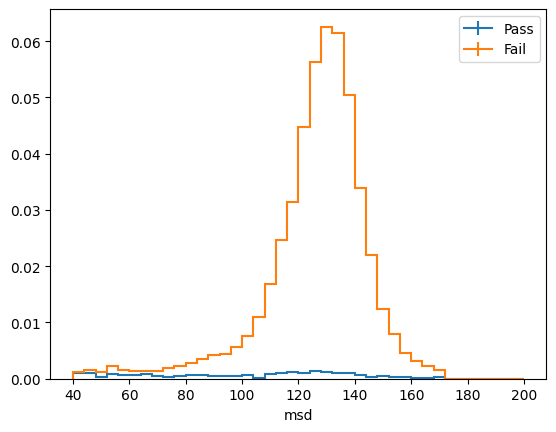

In [3]:
file["shapes_prefit/ptbin0pass/hbb;1"].to_hist().plot1d(density=False, label='Pass')
file["shapes_prefit/ptbin0fail/hbb;1"].to_hist().plot1d(density=False, label='Fail')
plt.legend()
plt.show()

In [90]:
# samples = os.listdir("/project01/ndcms/cmoore24/samples")
# samples
# stitched_samples = ['qcd', 'ttboosted', 'wqq', 'zqq']
# standalone_samples = ['hgg', 'hbb', 'singletop']
# diboson_samples = ['ww', 'wz', 'zz']

In [89]:
# event_totals = {}
# for i in stitched_samples:
#     dirs = os.listdir(f'/project01/ndcms/cmoore24/samples/{i}')
#     region_files = {}
#     for j in dirs:
#         nopath_files = os.listdir(f"/project01/ndcms/cmoore24/samples/{i}/{j}")
#         path_files = [f"/project01/ndcms/cmoore24/samples/{i}/{j}/" + file for file in nopath_files]
#         region_files[j] = path_files
#     nevents = {}
#     for sample, files in region_files.items():
#         nevents[sample] = sum(item[2] for item in uproot.num_entries({file: "Events" for file in files}))
#     total_events = 0
#     for k in nevents:
#         total_events += nevents[k]
#     event_totals[i] = total_events

In [91]:
# for i in standalone_samples:
#     nopath_files = os.listdir(f"/project01/ndcms/cmoore24/samples/{i}/")
#     path_files = [f"/project01/ndcms/cmoore24/samples/{i}/" + file for file in nopath_files] 
#     events = sum(item[2] for item in uproot.num_entries({file: "Events" for file in path_files}))
#     event_totals[i] = events

# for i in diboson_samples:
#     nopath_files = os.listdir(f"/project01/ndcms/cmoore24/samples/diboson/{i}/")
#     path_files = [f"/project01/ndcms/cmoore24/samples/diboson/{i}/" + file for file in nopath_files] 
#     events = sum(item[2] for item in uproot.num_entries({file: "Events" for file in path_files}))
#     event_totals[i] = events

In [94]:
# with open('event_total.json', 'w') as f:
#     json.dump(event_totals, f)

In [102]:
# with open('xsec.json', 'rb') as f:
#     xsecs = json.load(f)
# xsecs
# my_xsecs = {}
# my_xsecs['hbb'] = xsecs['GluGluHToBB']
# my_xsecs['hgg'] = 0.471
# my_xsecs['qcd'] = xsecs['QCD_Pt_300to470']
# my_xsecs['wqq'] = xsecs['WJetsToQQ_HT-600to800']
# my_xsecs['zqq'] = xsecs['ZJetsToQQ_HT-600to800']
# my_xsecs['ttboosted'] = xsecs['TT_MTT700To1000']
# my_xsecs['singletop'] = 7.104
# my_xsecs['ww'] = xsecs['WW']
# my_xsecs['wz'] = xsecs['WZ']
# my_xsecs['zz'] = xsecs['ZZ']
# with open('my_xsecs.json', 'w') as f:
#     json.dump(my_xsecs, f)

In [105]:
def plotter(sample, sample_score, density, wp, fail, var):
    if fail:
        sample_cut_msd = bkg_dict[sample][f'FatJets.{var}'][sample_score < wp]
        regime = 'Failing'
    else:
        sample_cut_msd = bkg_dict[sample][f'FatJets.{var}'][sample_score > wp]
        regime = 'Passing'
    plt.hist(sample_cut_msd, range=(0,0.5), bins=30, density=density, histtype='step', label=f'NN Cut {sample}')
    plt.hist(bkg_dict[sample][f'FatJets.{var}'], range=(0,0.5), bins=30, density=density, histtype='step', label=sample)
    plt.legend()
    if density:
        plt.title(f'Density Plot, {sample} With and Without NN Cut, {regime} WP = {wp}')
    else:
        plt.title(f'{sample} With and Without NN Cut, {regime} WP = {wp}')
    plt.show()

In [26]:
wqq_pn = bkg_dict['wqq']['FatJets.particleNet_HbbvsQCD']
wqq_pn_md = bkg_dict['wqq']['FatJets.particleNetMD_QCD']

zqq_pn = bkg_dict['zqq']['FatJets.particleNet_HbbvsQCD']
zqq_pn_md = bkg_dict['zqq']['FatJets.particleNetMD_QCD']

ttboosted_pn = bkg_dict['ttboosted']['FatJets.particleNet_HbbvsQCD']
ttboosted_pn_md = bkg_dict['ttboosted']['FatJets.particleNetMD_QCD']

singletop_pn = bkg_dict['singletop']['FatJets.particleNet_HbbvsQCD']
singletop_pn_md = bkg_dict['singletop']['FatJets.particleNetMD_QCD']

ww_pn = bkg_dict['ww']['FatJets.particleNet_HbbvsQCD']
ww_pn_md = bkg_dict['ww']['FatJets.particleNetMD_QCD']

wz_pn = bkg_dict['wz']['FatJets.particleNet_HbbvsQCD']
wz_pn_md = bkg_dict['wz']['FatJets.particleNetMD_QCD']

zz_pn = bkg_dict['zz']['FatJets.particleNet_HbbvsQCD']
zz_pn_md = bkg_dict['zz']['FatJets.particleNetMD_QCD']

qcd_pn = bkg_dict['qcd']['FatJets.particleNet_HbbvsQCD']
qcd_pn_md = bkg_dict['qcd']['FatJets.particleNetMD_QCD']

signal_pn = signal['FatJets.particleNet_HbbvsQCD']
signal_pn_md = signal['FatJets.particleNetMD_QCD']

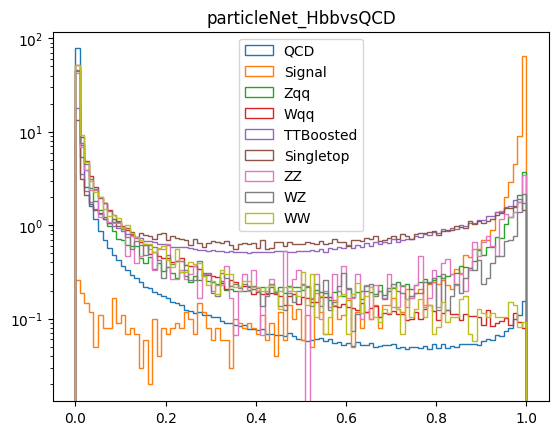

In [59]:
plt.hist(qcd_pn, bins=100, range=(0, 1), label='QCD', density=True, histtype='step')
plt.hist(signal_pn, bins=100, range=(0, 1), label='Signal', density=True, histtype='step')
plt.hist(zqq_pn, bins=100, range=(0, 1), label='Zqq', density=True, histtype='step')
plt.hist(wqq_pn, bins=100, range=(0, 1), label='Wqq', density=True, histtype='step')
plt.hist(ttboosted_pn, bins=100, range=(0, 1), label='TTBoosted', density=True, histtype='step')
plt.hist(singletop_pn, bins=100, range=(0, 1),  label='Singletop', density=True, histtype='step')
plt.hist(zz_pn, bins=100, range=(0, 1), label='ZZ', density=True, histtype='step')
plt.hist(wz_pn, bins=100, range=(0, 1), label='WZ', density=True, histtype='step')
plt.hist(ww_pn, bins=100, range=(0, 1), label='WW', density=True, histtype='step')
plt.title(f'particleNet_HbbvsQCD')
plt.yscale('log')
plt.legend()
plt.show()

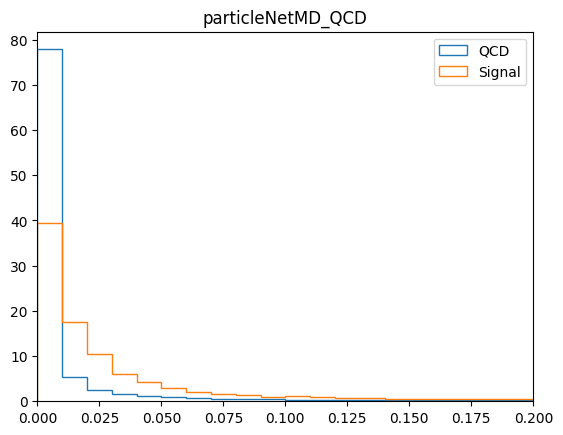

In [47]:
plt.hist(qcd_pn, bins=100, range=(0, 1), label='QCD', density=True, histtype='step')
plt.hist(signal_pn_md, bins=100, range=(0, 1), label='Signal', density=True, histtype='step')
#plt.hist(zqq_pn_md, bins=100, range=(0, 1), label='Zqq', density=True, histtype='step')
#plt.hist(wqq_pn_md, bins=100, range=(0, 1), label='Wqq', density=True, histtype='step')
#plt.hist(ttboosted_pn_md, bins=100, range=(0, 1), label='TTBoosted', density=True, histtype='step')
#plt.hist(singletop_pn_md, bins=100, range=(0, 1),  label='Singletop', density=True, histtype='step')
#plt.hist(zz_pn_md, bins=100, range=(0, 1), label='ZZ', density=True, histtype='step')
#plt.hist(wz_pn_md, bins=100, range=(0, 1), label='WZ', density=True, histtype='step')
#plt.hist(ww_pn_md, bins=100, range=(0, 1), label='WW', density=True, histtype='step')
plt.title(f'particleNetMD_QCD')
#plt.yscale('log')
plt.legend()
plt.xlim(0,0.2)
plt.show()

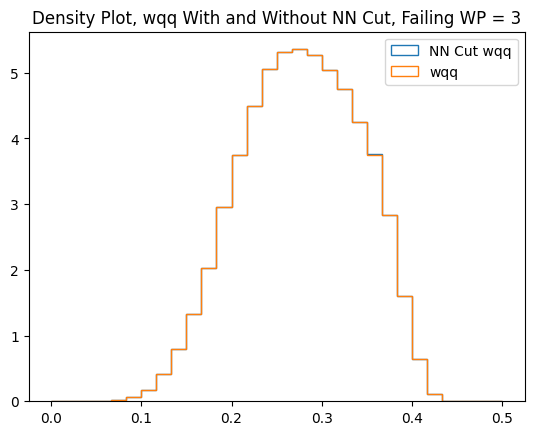

In [106]:
plotter('wqq', wqq_score, density=True, wp=3, fail=True, var='n2b1')

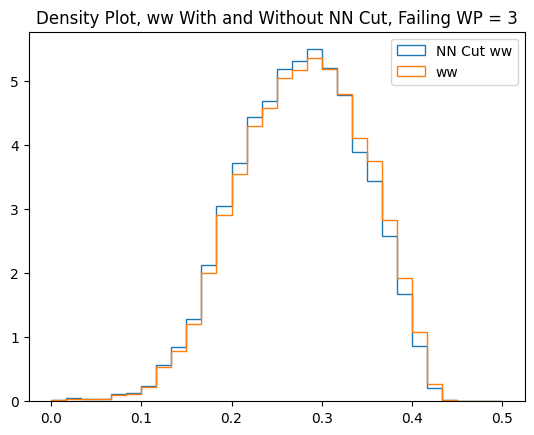

In [107]:
plotter('ww', ww_score, density=True, wp=3, fail=True, var='n2b1')